# 3115-Lab Programming Machine Learning

## Lab Exercise 7

## Yuvaraj Prem Kumar, 303384

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import operator
%matplotlib inline

plt.style.use('ggplot')

# K-NN


K-nearest neighbours is a classification or regression model, based on supervised learning. Informally, we have a labelled dataset consisting of training observations $(x,y)$ and would like to capture the relationship between $x$ and $y$. Formally, our goal is to learn a function $h:X→Y$l so that given an unseen observation $x$, $h(x)$ can confidently predict the corresponding output $y'$. K-NN has no 'learning' phase, meaning the algorithm doesn't actually learn a model. Instead it will memorize the training instances which are then used as the knowledge for predictions. I.e.; the algorithm will only call the training instance when asked to predict a label, given a particular input.

K-NN is computationally expensive, since classifying a particular observation (test phase) requires a whole pass through the training set. It also has a high memory cost, since we have to store the dataset in memory.

We are using the Iris dataset[1] here, which is well studied. The bulk of the code follows the Stanford CS231n [8] for CIFAR-10 dataset, adapted for use with the Iris dataset.

## Part 1: Data Preprocessing on Iris Dataset

This is a classification based dataset [1]. We have four attributes - sepal length, sepal width, petal length, and petal width - that defines if the flower belongs to one of the three particular classes:
* Iris Setosa
* Iris Versicolour
* Iris Virginica

Based on the dataset description, the following are noted:
1. Number of Instances: 150 (50 in each of three classes)
2. Number of Attributes: 4 numeric, predictive attributes and the class
3. Missing Attribute Values: None
4. Class Distribution: 33.3% for each of 3 classes

In [2]:
# Helper functions
def normalize(x):
    """We should just normalize the "X" aka observations
    """
    return (x - np.mean(x)) / np.std(x) 

def train_test_split(dfx, dfy):
    mask = np.random.rand(len(dfx)) < 0.7
    x_train, y_train = dfx[mask], dfy[mask]
    x_test, y_test = dfx[~mask], dfy[~mask]
    
    x_train = x_train.to_numpy()  # Unpack dataframe to numpy arrays
    y_train = y_train.to_numpy()
    x_test = x_test.to_numpy()
    y_test = y_test.to_numpy()

    print('\nShape of x_train:', x_train.shape, ';', 'Shape of y_train:', y_train.shape)
    print('\nShape of x_test:', x_test.shape, ';', 'Shape of y_test:', y_test.shape)
    
    return x_train, y_train, x_test, y_test


In [3]:
cols = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class']
df = pd.read_csv("iris.data", header = None, names = cols)
df.head(5)

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


We can visualize the initial dataset to better see the distributions of attributes and how they relate to their classes.

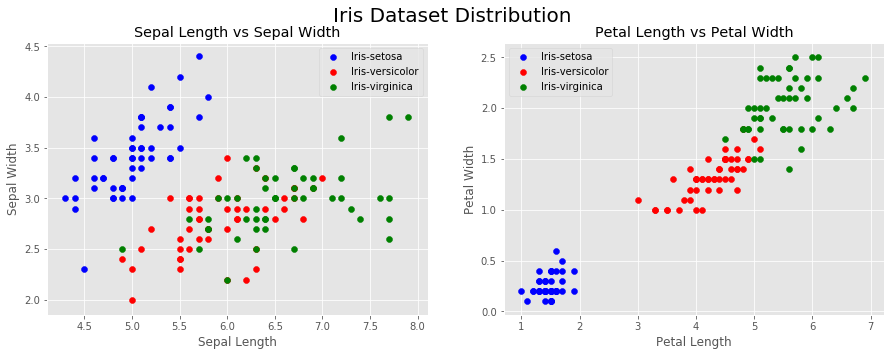

In [4]:
iris_class=['sentosa','versicolor','virginica']
colors=['blue','red','green']
labels=df['class'].unique()

for k in range(len(labels)):
    iris_class[k]=df[df['class'] == labels[k]]

# Plotting the distribution
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Iris Dataset Distribution', fontsize=20)
for i in range(len(iris_class)):
    ax[0].scatter(iris_class[i].sepal_length, iris_class[i].sepal_width, c=colors[i], label = labels[i])
    ax[0].set_title("Sepal Length vs Sepal Width")
    ax[0].set_xlabel('Sepal Length')
    ax[0].set_ylabel('Sepal Width')
    ax[0].legend()
    
    ax[1].scatter(iris_class[i].petal_length, iris_class[i].petal_width, c=colors[i], label = labels[i])
    ax[1].set_title("Petal Length vs Petal Width")
    ax[1].set_xlabel('Petal Length')
    ax[1].set_ylabel('Petal Width')
    ax[1].legend()
    
plt.show()

The current dataset values are all bunched up together, so we can shuffle the data. Then, convert the target column "class" from string to integers.

In [5]:
# Shuffle and replace string with integers
df1 = df.sample(frac=1).reset_index(drop=True)
df1['class'] = df1['class'].map({'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2})
df1.head(5)

,sepal_length,sepal_width,petal_length,petal_width,class
0,7.2,3.2,6.0,1.8,2
1,5.2,3.5,1.5,0.2,0
2,6.3,3.3,6.0,2.5,2
3,6.3,2.5,5.0,1.9,2
4,7.6,3.0,6.6,2.1,2


In [6]:
df2 = df1.iloc[:,:4].apply(lambda x: normalize(x), axis=0)
df2['class'] = df1['class']
df2.head(5)

,sepal_length,sepal_width,petal_length,petal_width,class
0,1.643844,0.337848,1.274550,0.790591,2
1,-0.779513,1.032057,-1.284407,-1.312977,0
2,0.553333,0.569251,1.274550,1.710902,2
3,0.553333,-1.281972,0.705893,0.922064,2
4,2.128516,-0.124958,1.615744,1.185010,2


In [7]:
# Split out into X (features) and Y (target)
dfx = df2.iloc[:, :4]
dfy = df2.iloc[:, -1]

In [42]:
# Its important to use the same random split, as my train/test split returns a different output each time due to random mask 
# k-NN computes the distances based on the location, hence the optimum value of k may change after rerun 
# Its not an issue, just to keep in mind this would cause my pdf report to be different from the code output 
# if random seed is not set
np.random.seed(19)
X_train, y_train, X_test, y_test = train_test_split(dfx, dfy)


Shape of x_train: (105, 4) ; Shape of y_train: (105,)

Shape of x_test: (45, 4) ; Shape of y_test: (45,)


## Part 2: Implement K-Nearest Neighbor (KNN)

**K-Nearest Neighbours Algorithm**

This algorithm is for classifying a test set to its predicted label, based on the distance measure among train sets [2]. For training, the classifier takes the training data and simply remembers it. Hence there is no "learning tasks" unlike previously implemented linear models. For testing, k-NN classifies every test set by comparing to all train sets and transfering the labels of the k-most similar training examples. The algorithm mainly follows the lecture slides below, and from [3]. The main steps are:
1. Compute distances between all test examples and all train examples.
2. With those distances, for each test example we find the **k-nearest** examples and have them vote for the label.

<img src="https://i.imgur.com/XWkzf4h.jpg" width="45%" align="left"/>
<img src="https://i.imgur.com/mIDZ6gn.jpg" width="45%" align="left"/>

**Distance measure**

For the distance measure, we are using the **Euclidean Distance**, which is also the L2 distance:

\begin{equation*}
d(x,x') = \sqrt{{(x_1-x'_2)}^2 +...+ {(x_n-x'_n)}^2}
\end{equation*}

In [9]:
def euclidean_dist(x1, x2):
    dist = np.sum(np.sqrt(np.square(x1 - x2)))
    return dist

**Scoring criteria**

For scoring criteria, as the Iris Dataset is a classification based task, we can apply an accuracy score and missclassification score. From sklearn.metrics.accuracy_score [5], we can recreate it and evaluate our KNN classifier model based on it. Basically it compares the number of matching counts from predicted label to the ground truth.

In [10]:
def acc_score(ytest_hat, ytest):
    acc = np.sum(ytest_hat == y_test) / len(y_test)
    return acc

**Error criteria**

Besides simply scoring the model, we can show the *misclassification rate* which is the proportion of misclassified observations [6]:

\begin{equation*}
\frac{1}{n}\sum{I(y_i \neq y_i')}
\end{equation*}

In [11]:
def misclassification(ytest_hat, ytest):
    misclass = np.round(1 - acc_score(ytest_hat, ytest), 5)
    return misclass

In [12]:
def argmin_k(X_train, y_train, x_test, k):
    """Function to calculate the array of distances, then sort by ascending order. 
    
    Input: X , y, xtest, k= number of nearest neighbour to compare and search distances
    Ouput: K-nearest neighbors, which are the first K distances), associated targel label
    
    Returns the argmax, the majority vote using python Counter.
    
    """
    distance_hist, target_label = [], []

    for i in range(len(X_train)):
        dist = euclidean_dist(x_test , X_train[i, :])
        distance_hist.append([dist, i])

    # Sorting in ascending order, meaning the shortest distance
    sorted_distance_hist = sorted(distance_hist)

    # This is our specified number of 'K' nearest neighbours to investigate the computed distance
    for i in range(k):
        index = sorted_distance_hist[i][1]
        target_label.append(y_train[index])

    # Counting the most common N (1), taken from [4]
    common_nn = Counter(target_label).most_common(1)[0][0]
    return common_nn

In [13]:
def predict_knn_class(X_train, y_train, X_test, k):
    predicted_labels = []

    # loop over all observations
    for i in range(len(X_test)):
        labels = argmin_k(X_train, y_train, X_test[i, :], k)
        predicted_labels.append(labels)
    
    return predicted_labels

In [43]:
# Manually testing values of k
k=[1,2,3,5,7,10,20,50,80]

acc_hist, misclass_hist = [], []

for i in range(len(k)):
    ytest_hat = predict_knn_class(X_train, y_train, X_test, k[i])
    acc = acc_score(ytest_hat, y_test) * 100
    misclass = misclassification(ytest_hat, y_test)
    
    acc_hist.append(acc)
    misclass_hist.append(misclass)
    
    print ('K-NN Classifier model accuracy for "k" = {} -----> {:0.4f}% & misclassification error of {}'
           .format(k[i], acc, misclass))

K-NN Classifier model accuracy for "k" = 1 -----> 95.5556% & misclassification error of 0.04444
K-NN Classifier model accuracy for "k" = 2 -----> 95.5556% & misclassification error of 0.04444
K-NN Classifier model accuracy for "k" = 3 -----> 95.5556% & misclassification error of 0.04444
K-NN Classifier model accuracy for "k" = 5 -----> 95.5556% & misclassification error of 0.04444
K-NN Classifier model accuracy for "k" = 7 -----> 95.5556% & misclassification error of 0.04444
K-NN Classifier model accuracy for "k" = 10 -----> 95.5556% & misclassification error of 0.04444
K-NN Classifier model accuracy for "k" = 20 -----> 95.5556% & misclassification error of 0.04444
K-NN Classifier model accuracy for "k" = 50 -----> 91.1111% & misclassification error of 0.08889
K-NN Classifier model accuracy for "k" = 80 -----> 80.0000% & misclassification error of 0.2


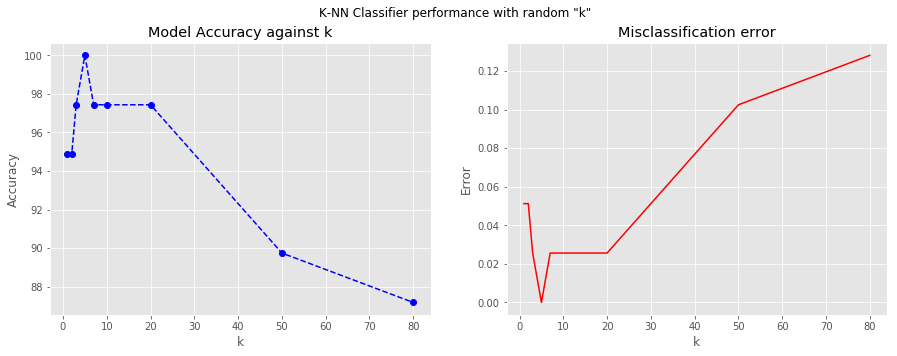

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('K-NN Classifier performance with random "k"')
ax[0].plot(k, acc_hist, linestyle='dashed', marker='o', color='blue')
ax[0].set_title("Model Accuracy against k")
ax[0].set_xlabel('k')
ax[0].set_ylabel('Accuracy')
 
ax[1].plot(k, misclass_hist, color='red')
ax[1].set_title("Misclassification error")
ax[1].set_xlabel('k')
ax[1].set_ylabel('Error')

plt.show()

Anyway we are simply inputting manual values for *'k'* without discovering the optimum values. Having said that, let's check the predicted labels for a sample value of *'k' = 5*.

In [34]:
ytest_hat = predict_knn_class(X_train, y_train, X_test, 5)

class_map={0:'Iris-setosa', 1:'Iris-versicolor', 2:'Iris-virginica'}
df_labels = pd.DataFrame({'Features':np.round(X_test,4).tolist(), 'Ground Truth':y_test, 'Predicted Class': ytest_hat})
df_labels['Ground Truth Label'] = df_labels['Ground Truth'].map(class_map)
df_labels['Predicted Label'] = df_labels['Predicted Class'].map(class_map)
df_labels.head(10)

,Features,Ground Truth,Predicted Class,Ground Truth Label,Predicted Label
0,"[2.1285, -0.125, 1.6157, 1.185]",2,2,Iris-virginica,Iris-virginica
1,"[-0.9007, 1.7263, -1.2844, -1.1815]",0,0,Iris-setosa,Iris-setosa
2,"[-1.7489, 0.3378, -1.3981, -1.313]",0,0,Iris-setosa,Iris-setosa
3,"[0.6745, -0.5878, 1.0471, 1.3165]",2,2,Iris-virginica,Iris-virginica
4,"[-1.143, 0.1064, -1.2844, -1.4444]",0,0,Iris-setosa,Iris-setosa
5,"[-0.2948, -0.125, 0.4216, 0.3962]",1,1,Iris-versicolor,Iris-versicolor
6,"[0.4322, -1.9762, 0.4216, 0.3962]",1,1,Iris-versicolor,Iris-versicolor
7,"[0.7957, -0.125, 1.1608, 1.3165]",2,2,Iris-virginica,Iris-virginica
8,"[-1.0218, 1.0321, -1.3981, -1.1815]",0,0,Iris-setosa,Iris-setosa
9,"[1.2803, 0.1064, 0.649, 0.3962]",1,1,Iris-versicolor,Iris-versicolor


## Part 2: Determine Optimal Value of K in KNN algorithm

We can use k-folds cross-validation with Grid-Search technique to tune our hyperparameter $k$ and find the optimal value of $k$. Since the Iris dataset is not large, we can exhaustively run the k-nearest-neighbor algorithm for chosen k-fold (default 5) times. Meaning, in each case we use all but one of the folds as training data and the last fold as a validation set. Then the prediction is done on that set, and the related accuracies are computed.

The code adapted from [2] and [7].

In [35]:
def kfolds_cv(X_train, y_train, k_folds, k_list):
    """Function to have k-folds cross validation on the training dataset
    
    Input: X, y, number of k-folds (default - 5), possible choices for k, not to exceed length of X
    
    Split the training data into folds, where X_folds and y_folds are arrays of length k-folds. y_fold[i] will be the 
    label vector for datapoints in X_fold[i]. Predicted labels and related accuracy are computed and stored in a dict. 
    
    Output: k_to_accuracies[k] a list of length num_folds giving the different accuracy values that we found 
    when using that value of k.
    """
    n_split = X_train.shape[0] / k_folds
    
    X_train_folds, y_train_folds = [], []
    
    X_train_folds = np.array_split(X_train, k_folds)
    y_train_folds = np.array_split(y_train, k_folds)
    
    k_to_accuracies = {}  # Dict
    
    acc_k = np.zeros((len(k_list), k_folds), dtype=np.float)
    
    for j, k in enumerate(k_list):
        for i in range(k_folds):
            X_train_cv = np.concatenate((X_train_folds[:i]+X_train_folds[i+1:]))
            y_train_cv = np.concatenate((y_train_folds[:i]+y_train_folds[i+1:]))
            ytest_hat = predict_knn_class(X_train_cv, y_train_cv, X_train_folds[i], k=k)       
            acc_k[j, i] = float(np.sum(ytest_hat == y_train_folds[i])) / n_split
        k_to_accuracies[k] = acc_k[j]
    
    return k_to_accuracies

In [44]:
# Range of hyperparameter 'k', not to be confused with k-folds of 5
k_folds = 5
k_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 50]

k_to_accuracies = kfolds_cv(X_train, y_train, k_folds, k_list)

for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('For k = %d; Classifier model accuracy = %f' % (k, accuracy))

For k = 1; Classifier model accuracy = 0.857143
For k = 1; Classifier model accuracy = 0.952381
For k = 1; Classifier model accuracy = 1.000000
For k = 1; Classifier model accuracy = 1.000000
For k = 1; Classifier model accuracy = 0.952381
For k = 2; Classifier model accuracy = 0.857143
For k = 2; Classifier model accuracy = 0.952381
For k = 2; Classifier model accuracy = 1.000000
For k = 2; Classifier model accuracy = 1.000000
For k = 2; Classifier model accuracy = 0.952381
For k = 3; Classifier model accuracy = 0.809524
For k = 3; Classifier model accuracy = 0.952381
For k = 3; Classifier model accuracy = 1.000000
For k = 3; Classifier model accuracy = 0.952381
For k = 3; Classifier model accuracy = 1.000000
For k = 4; Classifier model accuracy = 0.857143
For k = 4; Classifier model accuracy = 0.952381
For k = 4; Classifier model accuracy = 1.000000
For k = 4; Classifier model accuracy = 0.952381
For k = 4; Classifier model accuracy = 1.000000
For k = 5; Classifier model accuracy = 0

In [45]:
print('Dictionary values:')
for key,value in k_to_accuracies.items():
    print("k_accuracy[%s] = %s" % (key,value))


Dictionary values:
k_accuracy[1] = [0.85714286 0.95238095 1.         1.         0.95238095]
k_accuracy[2] = [0.85714286 0.95238095 1.         1.         0.95238095]
k_accuracy[3] = [0.80952381 0.95238095 1.         0.95238095 1.        ]
k_accuracy[4] = [0.85714286 0.95238095 1.         0.95238095 1.        ]
k_accuracy[5] = [0.9047619  0.95238095 1.         0.95238095 1.        ]
k_accuracy[6] = [0.85714286 0.95238095 1.         0.95238095 1.        ]
k_accuracy[7] = [0.9047619  0.95238095 1.         0.95238095 1.        ]
k_accuracy[8] = [0.85714286 0.95238095 1.         0.95238095 1.        ]
k_accuracy[9] = [0.85714286 0.95238095 1.         0.95238095 1.        ]
k_accuracy[10] = [0.85714286 0.95238095 1.         0.95238095 1.        ]
k_accuracy[12] = [0.9047619  0.95238095 1.         0.95238095 1.        ]
k_accuracy[15] = [0.85714286 0.95238095 1.         1.         1.        ]
k_accuracy[20] = [0.85714286 0.95238095 1.         1.         0.95238095]
k_accuracy[50] = [0.9047619 

So we get the list of accuracies, corresponding to our 5 folds of cross validation. Now we can plot the values, by computing the mean and standard deviation of the accuracy spreads.

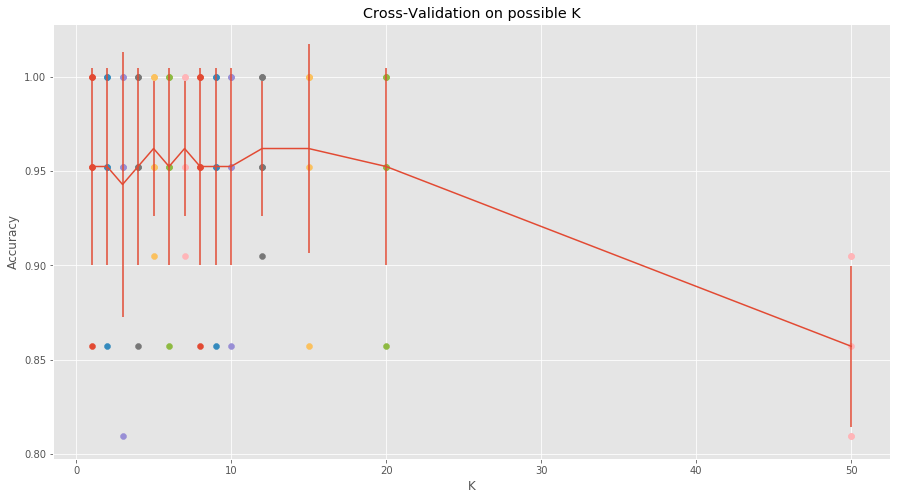

In [46]:
plt.figure(figsize=(15,8)) 
for k in k_list:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_list, accuracies_mean, yerr=accuracies_std)

plt.title('Cross-Validation on possible K')
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.show()

Based on the above, we can pick the best value of $k$, and run our K-NN Classifier model using that optimal value

In [52]:
optimum_k = 9
ytest_hat = predict_knn_class(X_train, y_train, X_test, optimum_k)
acc = acc_score(ytest_hat, y_test) * 100
misclass = misclassification(ytest_hat, y_test)
print ('K-NN Classifier model accuracy for "k" = {} -----> {:0.4f}% & misclassification error of {}'
       .format(optimum_k, acc, misclass))

K-NN Classifier model accuracy for "k" = 9 -----> 95.5556% & misclassification error of 0.04444


## Summary


* We used k-NN for classification of the Iris dataset, to predict the class label given four observations.
* There are multiple hyper-parameters (such as value of k, or the type of distance used to compare examples) that could be used.
* For the distance measure, L2 distance or Euclidean distance was chosen. 
* The optimal value of $k$ was selected via cross-validation
* Cross validation helps when there is a lack of training data, as it helps to reduce noise in estimating which hyperparameters work best.
* After getting the optimal value of $k$ (there are few with same accuracy, hence we can choose randomly) we perform a single evaluation on the actual test set.
* k-NN is simple to implement but requires to store the entire training set. Also it is computationally expensive to evaluate on a test set.
* However, the Iris dataset is small enough, and the values are highly homogenous in a multidimensional setting. Hence it is very easy to obtain high accuracies (>90%) for a wide range of $k$ values.
* **In fact depending on how is the arrangement of the training and test dataset after the random split, it is possible to achieve even 100% accuracy (which I get somtimes, due to the randomness of the shuffle).**

## References

[1] https://archive.ics.uci.edu/ml/datasets/Iris <br>
[2] https://github.com/MahanFathi/CS231/blob/master/assignment1/knn.ipynb <br>
[3] https://kevinzakka.github.io/2016/07/13/k-nearest-neighbor/ <br>
[4] https://stackoverflow.com/questions/19850856/manipulating-counter-information-python-2-7 <br>
[5] https://mahata.github.io/machine%20learning/2014/12/31/sklearn-accuracy_score/ <br>
[6] https://stats.stackexchange.com/questions/146294/what-is-misclassification-rate-how-do-we-calculate-it <br>
[7] https://medium.com/@avulurivenkatasaireddy/k-nearest-neighbors-and-implementation-on-iris-data-set-f5817dd33711 <br>
[8] http://cs231n.github.io/classification/ <br>